# ALBERT + InceptionNet
In this notebook I try to train ALBERT (a reduced version of BERT and classify the outputs with Inception NEt)

In [203]:
import tensorflow_hub as hub
import tensorflow as tf
#import bert
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from utils import *

In [204]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt

df_bitcoin = pd.read_csv("csv/articles_Bitcoin-Cryptocurrency_start=2019-01-01_end=2020-12-31.csv", index_col = 0)
df_tesla = pd.read_csv("csv/articles_Tesla-Elon_Musk_start=2019-01-01_end=2020-12-31.csv", index_col = 0)
df = df_bitcoin

In [205]:
import yfinance as yf

start = "2019-01-01"
end   = "2020-03-20"

stocks = ["TSLA"]
keywords = {"TSLA": ["Tesla", "Elon Musk"]}
stocks = ["BTC-USD"]
keywords = {"BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

df_financial = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
prices = df_financial["Close"]

In [206]:
prices = pd.DataFrame(data = prices, index = pd.date_range(start,end)).fillna(method = "bfill")

### Split sentences

#### ~Titles and descriptions

In [4]:
# titles and descriptions
titles = df.title
titles.index = df["date_google"]
descriptions = df.description
descriptions.index = df["date_google"]
text = pd.concat([titles,descriptions]).sort_index().dropna()

#### Whole text 

In [207]:
# main_text
text = df.maintext #pd.DataFrame(df.maintext.values, index = df["date_google"]).dropna()
text.index = df["date_google"]

In [17]:
import nltk.data

split_sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [208]:
split_sentences = text.apply(split_sentence_tokenizer.tokenize)
split_sentences = split_sentences.groupby(split_sentences.index).sum()
split_sentences = pd.DataFrame(split_sentences)

In [209]:
split_sentences.head()

,maintext
date_google,
2019-01-01,[Cryptocurrency exchange HitBTC has frozen its...
2019-01-02,"[Back in December 2017, when its price reached..."
2019-01-03,"[Do your bitcoins really exist?, The answer mi..."
2019-01-04,[Renowned investor Gary Shilling believes Bitc...
2019-01-05,[Coinbase and Its Troubling History of Custome...


In [23]:
#pd.to_pickle(split_sentences,"sentences/TSLA_articles", protocol = 3)

In [53]:
split_sentences = pd.read_pickle("sentences/BTC_articles")

In [41]:
import importlib
import utils
importlib.reload(utils)
from utils import *

bert-for-tf2 not installed


In [210]:
keywords_bitcoin = ["crypto", "BTC", "bitcoin", "blockchain"]
keywords_tesla =   ["tesla", "Elon", "Musk", "TSLA"]
raw_text = "".join(text.values).replace(".com","-com").replace(".", "").replace(",", "").replace("“", "").replace("”", "").replace("\n", " ").replace("-com",".com")
new_tokens = find_new_token_with_custom_keywords(text.values, keywords_bitcoin, 6, ["btc"])

New tokens to be added:  ['bitcoin', 'cryptocurrency', 'crypto', 'cryptocurrencies', 'blockchain', 'bitcoin’s', 'btc']


In [211]:
from transformers import AlbertTokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
tokenizer.add_tokens(new_tokens)

7

In [213]:
df_ret = label_transformer(prices.copy(), shift = 1)

split_sentences, df_ret = series_intersection(split_sentences, df_ret)
raw_sentences, raw_labels = generate_data_for_tokenizer(split_sentences,df_ret)

lengths = raw_sentences.apply(lambda x: len(x[0].split()), axis = 1)
sentences = raw_sentences[(lengths > 10) & (lengths < 120)] #filter short and long sentences
labels = raw_labels[(lengths > 10) & (lengths < 120)]

threshold = "2020-01-01"
train_sentences = sentences.loc[:"2019-12-31"]
test_sentences = sentences.loc["2020-01-01":]
train_labels = labels.loc[:"2019-12-31"]
test_labels = labels.loc["2020-01-01":]

[]

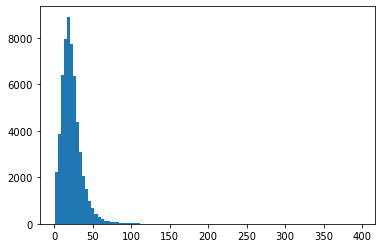

In [214]:
plt.hist(lengths, bins = 100)
plt.plot()

In [24]:
print(train_sentences.values[0])
print(tokenizer.tokenize(train_sentences.values[0][0]))

['The answer might seem like an obvious “yes,” but the brewing “Proof of Keys” movement, launching today, argues the answer is not so clear.']
['▁the', '▁answer', '▁might', '▁seem', '▁like', '▁an', '▁obvious', '▁', '“', 'yes', ',', '”', '▁but', '▁the', '▁brewing', '▁', '“', 'proof', '▁of', '▁keys', '”', '▁movement', ',', '▁launching', '▁today', ',', '▁argues', '▁the', '▁answer', '▁is', '▁not', '▁so', '▁clear', '.']


In [215]:
max_seq_length = 80
train_input_ids, train_input_masks, train_segment_ids = convert_sentences_to_features(train_sentences.values.flatten(), tokenizer, max_seq_length)
test_input_ids, test_input_masks, test_segment_ids = convert_sentences_to_features(test_sentences.values.flatten(), tokenizer, max_seq_length)


In [219]:
i = 32
print(train_sentences.values[i])
print(train_input_ids[i])
print(train_input_masks[i])
print(train_segment_ids[i])

['“I think most companies and individuals will operate normally with no significant interruptions, the bitcoin network will be strengthened in its decentralization properties, and many individuals and the community will have a sense of accomplishment and camaraderie,” Mayer told CoinDesk.']
[2, 13, 1, 49, 277, 127, 1532, 17, 1883, 129, 4055, 4147, 29, 90, 1505, 21786, 18, 15, 14, 30000, 982, 129, 44, 15908, 19, 82, 121, 6306, 1829, 3704, 15, 17, 151, 1883, 17, 14, 514, 129, 57, 21, 1259, 16, 26446, 17, 16787, 13065, 3272, 15, 1, 123, 106, 470, 8646, 3196, 197, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### If we want to permute training inputs

In [220]:
size = len(train_input_ids)
p = np.random.permutation(size)
train_input_ids = np.array(train_input_ids)[p]
train_input_masks = np.array(train_input_masks)[p]
train_segment_ids = np.array(train_segment_ids)[p]
train_labels = pd.DataFrame(train_labels.values[p], index = train_labels.index[p])

In [221]:
train_inputs = {
     "input_ids": np.array(train_input_ids),
     "input_mask": np.array(train_input_masks),
     "segment_ids": np.array(train_segment_ids),
     }

test_inputs = {
     "input_ids": np.array(test_input_ids),
     "input_mask": np.array(test_input_masks ),
     "segment_ids": np.array(test_segment_ids),
     }

In [223]:
y_train = np.where(train_labels > 0, 1, 0)
y_test  = np.where(test_labels  > 0, 1, 0)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False )
y_train_ohe = ohe.fit_transform(y_train)
y_test_ohe = ohe.fit_transform(y_test)

In [ ]:
#https://medium.com/analytics-vidhya/bert-in-keras-tensorflow-2-0-using-tfhub-huggingface-81c08c5f81d8

## BERT model 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from transformers import TFAlbertModel


In [185]:
from importlib import reload
import inception
reload(inception)

<module 'inception' from 'C:\\Users\\HPfamiliaRuiz-Tagle\\Documents\\JUAN_LUIS\\stock-prediction-nlp\\inception.py'>

In [227]:
def build_model(max_seq_length):
    # Build model
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
    input_masks = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    input_segments = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
    bert_inputs = [input_word_ids, input_masks, input_segments]
    
    albert_inputs = dict(input_ids=input_word_ids, input_mask=input_masks, segment_ids=input_segments)
    
    #albert_model = TFAlbertModel.from_pretrained("albert-base-v2")
    #sequence_output, pooled_output = albert_model([input_word_ids, input_masks, input_segments])
    
    
    hub_url = "https://tfhub.dev/google/albert_base/3"
    albert = hub.KerasLayer(hub_url, trainable=False, signature="tokens", signature_outputs_as_dict =True)
    
    albert_outputs = albert(albert_inputs)
    pooled_output = albert_outputs["pooled_output"]
    sequence_output = albert_outputs["sequence_output"]
    
   
    #INCEPTION
    inception_model  = inception.Classifier_INCEPTION("models/",[max_seq_length,768],2, verbose = True, nb_epochs = 1500, build = False)
    inception_output_tensor = inception_model.build_layer_structure(sequence_output)

    
    # Build the rest of the classifier 
    dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(inception_output_tensor)
    #dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(dense)
    pred = tf.keras.layers.Dense(2, activation = 'sigmoid', name = "output")(dense)

    model = tf.keras.models.Model(inputs= albert_inputs, outputs= pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
    return model

### BERT output

In [95]:
print(len(train_input_ids) == len(train_labels))
print(len(test_input_ids) == len(test_labels))

True
True


In [228]:
albert_model = build_model(80)

In [229]:
albert_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 80)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 80)]         0                                            
__________________________________________________________________________________________________
keras_layer_22 (KerasLayer)     {'sequence_output':  11812272    input_ids[0][0]                  
                                                                 input_mask[0][0]          

In [231]:
import datetime
start = datetime.datetime.now()
print(start)

history = bert_model.fit(x = train_inputs, 
    y = y_train_ohe,
    validation_data=(test_inputs, y_test_ohe),
    epochs=20,
    batch_size=16
)
end = datetime.datetime.now()
print(start - end)

2020-04-20 23:49:36.942581
Epoch 1/20
2517/2517 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.5355WARNING:tensorflow:Model was constructed with shape (None, 120) for input Tensor("input_ids_12:0", shape=(None, 120), dtype=int32), but it was called on an input with incompatible shape (None, 80).


2517/2517 [==============================] - 760s 302ms/step - loss: 0.6907 - accuracy: 0.5355 - val_loss: 0.6971 - val_accuracy: 0.4855
Epoch 2/20
2517/2517 [==============================] - 758s 301ms/step - loss: 0.6906 - accuracy: 0.5355 - val_loss: 0.6987 - val_accuracy: 0.4855
Epoch 3/20
2517/2517 [==============================] - 758s 301ms/step - loss: 0.6907 - accuracy: 0.5355 - val_loss: 0.6975 - val_accuracy: 0.4855
Epoch 4/20
2517/2517 [==============================] - 758s 301ms/step - loss: 0.6907 - accuracy: 0.5355 - val_loss: 0.6973 - val_accuracy: 0.4855
Epoch 5/20
2517/2517 [==============================] - 758s 301ms/step - loss: 0.6906 - accuracy: 0.5355 - val_loss: 0.6987 - val_accuracy: 0.4855
Epoch 6/20
2517/2517 [==============================] - 758s 301ms/step - loss: 0.6907 - accuracy: 0.5355 - val_loss: 0.6977 - val_accuracy: 0.4855
Epoch 7/20
2517/2517 [==============================] - 758s 301ms/step - loss: 0.6907 - accuracy: 0.5355 - val_loss: 0.697

In [232]:
predictions = albert_model.predict(test_inputs, batch_size=32)

In [234]:
predictions.shape

(8425, 2)

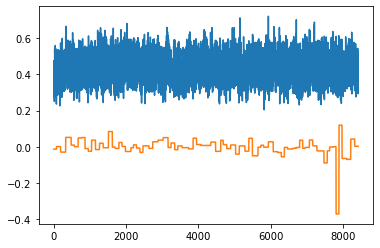

In [235]:
plt.plot(predictions.T[0])
plt.plot(test_labels.values)
plt.show()

In [ ]:
bert_model.evaluate()

In [151]:
name = "bitcoin_title_description"

In [159]:
np.save("features_labels/train_bert_{}_output_pooled".format(name),train_bert_output[0])
np.save("features_labels/train_bert_{}_output_sequence".format(name),train_bert_output[1])

In [153]:
np.save("features_labels/test_bert_{}_output_pooled".format(name),test_bert_output[0])
np.save("features_labels/test_bert_{}_output_sequence".format(name),test_bert_output[1])

In [154]:
label_name = "bitcoin_ret1days"
pd.to_pickle(train_labels, "features_labels/train_{}_labels".format(label_name))
pd.to_pickle(test_labels, "features_labels/test_{}_labels".format(label_name))

In [155]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [26]:
train_bert_output[0].shape

(40522, 768)

In [30]:
print(train_inputs["input_ids"].shape)
print(train_inputs["input_mask"].shape)
print(train_inputs["segment_ids"].shape)

(40522, 120)
(40522, 120)
(40522, 120)


## LSTM

- https://ieeexplore.ieee.org/document/8141873
- https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [53]:
from inception import Classifier_INCEPTION

In [54]:
X_train_tr = X_train_tr.reshape(X_train_tr.shape[0],1,X_train_tr.shape[1])
X_test_tr  = X_test_tr.reshape(X_test_tr.shape[0], 1,X_test_tr.shape[1])

ValueError: cannot reshape array of size 80424960 into shape (2618,1,40)

In [60]:
hist = inception.fit(X_train_tr, y_train_ohe, X_test_tr, y_test_ohe, y_train, plot_test_acc=True)

Epoch 1/1500
41/41 [==============================] - 2s 55ms/step - loss: 0.7708 - accuracy: 0.5034 - val_loss: 1.1733 - val_accuracy: 0.4864 - lr: 0.0010
Epoch 2/1500
41/41 [==============================] - 1s 25ms/step - loss: 0.6326 - accuracy: 0.6524 - val_loss: 0.7902 - val_accuracy: 0.4928 - lr: 0.0010
Epoch 3/1500
41/41 [==============================] - 1s 25ms/step - loss: 0.5331 - accuracy: 0.7594 - val_loss: 0.8429 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 4/1500
41/41 [==============================] - 1s 25ms/step - loss: 0.3958 - accuracy: 0.8304 - val_loss: 1.0313 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 5/1500
41/41 [==============================] - 1s 25ms/step - loss: 0.2362 - accuracy: 0.9106 - val_loss: 1.2369 - val_accuracy: 0.4944 - lr: 0.0010
Epoch 6/1500
41/41 [==============================] - 1s 25ms/step - loss: 0.1371 - accuracy: 0.9488 - val_loss: 1.3672 - val_accuracy: 0.5024 - lr: 0.0010
Epoch 7/1500
41/41 [==============================] - 1s 25ms/st

41/41 [==============================] - 1s 22ms/step - loss: 0.0044 - accuracy: 0.9958 - val_loss: 2.6556 - val_accuracy: 0.4751 - lr: 0.0010
Epoch 106/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0040 - accuracy: 0.9973 - val_loss: 2.6527 - val_accuracy: 0.4767 - lr: 5.0000e-04
Epoch 107/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0041 - accuracy: 0.9966 - val_loss: 2.6518 - val_accuracy: 0.4767 - lr: 5.0000e-04
Epoch 108/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0040 - accuracy: 0.9969 - val_loss: 2.6585 - val_accuracy: 0.4815 - lr: 5.0000e-04
Epoch 109/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0041 - accuracy: 0.9966 - val_loss: 2.6592 - val_accuracy: 0.4799 - lr: 5.0000e-04
Epoch 110/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0040 - accuracy: 0.9969 - val_loss: 2.6669 - val_accuracy: 0.4815 - lr: 5.0000e-04
Epoch 111/1500
41/41 [=========================

Epoch 156/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0040 - accuracy: 0.9966 - val_loss: 2.8921 - val_accuracy: 0.4767 - lr: 5.0000e-04
Epoch 157/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0040 - accuracy: 0.9969 - val_loss: 2.9107 - val_accuracy: 0.4815 - lr: 5.0000e-04
Epoch 158/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0039 - accuracy: 0.9966 - val_loss: 2.9204 - val_accuracy: 0.4751 - lr: 5.0000e-04
Epoch 159/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0040 - accuracy: 0.9969 - val_loss: 2.9167 - val_accuracy: 0.4783 - lr: 5.0000e-04
Epoch 160/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0040 - accuracy: 0.9962 - val_loss: 2.9143 - val_accuracy: 0.4783 - lr: 5.0000e-04
Epoch 161/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0041 - accuracy: 0.9969 - val_loss: 2.9103 - val_accuracy: 0.4719 - lr: 5.0000e-04
Epoch 162/1500
41/41 [======

Epoch 257/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9962 - val_loss: 3.2232 - val_accuracy: 0.4831 - lr: 1.2500e-04
Epoch 258/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0039 - accuracy: 0.9958 - val_loss: 3.2273 - val_accuracy: 0.4815 - lr: 1.2500e-04
Epoch 259/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9966 - val_loss: 3.2336 - val_accuracy: 0.4815 - lr: 1.2500e-04
Epoch 260/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9962 - val_loss: 3.2346 - val_accuracy: 0.4799 - lr: 1.2500e-04
Epoch 261/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9962 - val_loss: 3.2409 - val_accuracy: 0.4815 - lr: 1.2500e-04
Epoch 262/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9966 - val_loss: 3.2328 - val_accuracy: 0.4767 - lr: 1.2500e-04
Epoch 263/1500
41/41 [======

41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 3.3766 - val_accuracy: 0.4767 - lr: 1.0000e-04
Epoch 308/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 3.3739 - val_accuracy: 0.4799 - lr: 1.0000e-04
Epoch 309/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9969 - val_loss: 3.3777 - val_accuracy: 0.4799 - lr: 1.0000e-04
Epoch 310/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9969 - val_loss: 3.3933 - val_accuracy: 0.4767 - lr: 1.0000e-04
Epoch 311/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9966 - val_loss: 3.4060 - val_accuracy: 0.4751 - lr: 1.0000e-04
Epoch 312/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9962 - val_loss: 3.3955 - val_accuracy: 0.4799 - lr: 1.0000e-04
Epoch 313/1500
41/41 [=====================

Epoch 358/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9969 - val_loss: 3.5676 - val_accuracy: 0.4864 - lr: 1.0000e-04
Epoch 359/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 3.5926 - val_accuracy: 0.4815 - lr: 1.0000e-04
Epoch 360/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 3.5874 - val_accuracy: 0.4767 - lr: 1.0000e-04
Epoch 361/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9966 - val_loss: 3.5802 - val_accuracy: 0.4815 - lr: 1.0000e-04
Epoch 362/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9969 - val_loss: 3.5840 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 363/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 3.5678 - val_accuracy: 0.4848 - lr: 1.0000e-04
Epoch 364/1500
41/41 [======

41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 3.8047 - val_accuracy: 0.4880 - lr: 1.0000e-04
Epoch 409/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9958 - val_loss: 3.8135 - val_accuracy: 0.4848 - lr: 1.0000e-04
Epoch 410/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9958 - val_loss: 3.8036 - val_accuracy: 0.4864 - lr: 1.0000e-04
Epoch 411/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9958 - val_loss: 3.8066 - val_accuracy: 0.4912 - lr: 1.0000e-04
Epoch 412/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9954 - val_loss: 3.8050 - val_accuracy: 0.4896 - lr: 1.0000e-04
Epoch 413/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9962 - val_loss: 3.8198 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 414/1500
41/41 [=====================

Epoch 459/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9962 - val_loss: 4.1344 - val_accuracy: 0.4848 - lr: 1.0000e-04
Epoch 460/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 4.1171 - val_accuracy: 0.4880 - lr: 1.0000e-04
Epoch 461/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9962 - val_loss: 4.1173 - val_accuracy: 0.4815 - lr: 1.0000e-04
Epoch 462/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9958 - val_loss: 4.1619 - val_accuracy: 0.4815 - lr: 1.0000e-04
Epoch 463/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9966 - val_loss: 4.1418 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 464/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9969 - val_loss: 4.1442 - val_accuracy: 0.4751 - lr: 1.0000e-04
Epoch 465/1500
41/41 [======

Epoch 560/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9969 - val_loss: 4.5549 - val_accuracy: 0.4848 - lr: 1.0000e-04
Epoch 561/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 4.5499 - val_accuracy: 0.4880 - lr: 1.0000e-04
Epoch 562/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0038 - accuracy: 0.9973 - val_loss: 4.5523 - val_accuracy: 0.4896 - lr: 1.0000e-04
Epoch 563/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 4.5475 - val_accuracy: 0.4928 - lr: 1.0000e-04
Epoch 564/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 4.5428 - val_accuracy: 0.4944 - lr: 1.0000e-04
Epoch 565/1500
41/41 [==============================] - 1s 22ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 4.5443 - val_accuracy: 0.4944 - lr: 1.0000e-04
Epoch 566/1500
41/41 [======

Epoch 661/1500
41/41 [==============================] - 1s 26ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 4.6001 - val_accuracy: 0.4848 - lr: 1.0000e-04
Epoch 662/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9958 - val_loss: 4.6035 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 663/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 4.6049 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 664/1500
41/41 [==============================] - 1s 23ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 4.6056 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 665/1500
41/41 [==============================] - 1s 23ms/step - loss: 0.0037 - accuracy: 0.9958 - val_loss: 4.6055 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 666/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 4.6075 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 667/1500
41/41 [======

Epoch 762/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9966 - val_loss: 4.6917 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 763/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9962 - val_loss: 4.6916 - val_accuracy: 0.4767 - lr: 1.0000e-04
Epoch 764/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0038 - accuracy: 0.9958 - val_loss: 4.7003 - val_accuracy: 0.4751 - lr: 1.0000e-04
Epoch 765/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9962 - val_loss: 4.7162 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 766/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9958 - val_loss: 4.6921 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 767/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 4.6955 - val_accuracy: 0.4848 - lr: 1.0000e-04
Epoch 768/1500
41/41 [======

Epoch 863/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9966 - val_loss: 4.9740 - val_accuracy: 0.4751 - lr: 1.0000e-04
Epoch 864/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 4.9987 - val_accuracy: 0.4976 - lr: 1.0000e-04
Epoch 865/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9962 - val_loss: 4.9759 - val_accuracy: 0.4799 - lr: 1.0000e-04
Epoch 866/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 4.9736 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 867/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9950 - val_loss: 4.9961 - val_accuracy: 0.4719 - lr: 1.0000e-04
Epoch 868/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9962 - val_loss: 4.9916 - val_accuracy: 0.4799 - lr: 1.0000e-04
Epoch 869/1500
41/41 [======

Epoch 964/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9966 - val_loss: 5.0376 - val_accuracy: 0.4912 - lr: 1.0000e-04
Epoch 965/1500
41/41 [==============================] - 1s 23ms/step - loss: 0.0037 - accuracy: 0.9962 - val_loss: 5.0381 - val_accuracy: 0.4896 - lr: 1.0000e-04
Epoch 966/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 5.0392 - val_accuracy: 0.4912 - lr: 1.0000e-04
Epoch 967/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9966 - val_loss: 5.0418 - val_accuracy: 0.4912 - lr: 1.0000e-04
Epoch 968/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 5.0440 - val_accuracy: 0.4912 - lr: 1.0000e-04
Epoch 969/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9981 - val_loss: 5.0464 - val_accuracy: 0.4912 - lr: 1.0000e-04
Epoch 970/1500
41/41 [======

41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 5.3895 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 1065/1500
41/41 [==============================] - 1s 23ms/step - loss: 0.0038 - accuracy: 0.9969 - val_loss: 5.3947 - val_accuracy: 0.4848 - lr: 1.0000e-04
Epoch 1066/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 5.3892 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 1067/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 5.3828 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 1068/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 5.3829 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 1069/1500
41/41 [==============================] - 1s 23ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 5.3761 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 1070/1500
41/41 [===============

41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 5.3960 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 1165/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9966 - val_loss: 5.3961 - val_accuracy: 0.4815 - lr: 1.0000e-04
Epoch 1166/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 5.3986 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 1167/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 5.3926 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 1168/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9962 - val_loss: 5.3884 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 1169/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9958 - val_loss: 5.3837 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 1170/1500
41/41 [===============

41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9962 - val_loss: 5.4734 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 1265/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9966 - val_loss: 5.4583 - val_accuracy: 0.4848 - lr: 1.0000e-04
Epoch 1266/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9962 - val_loss: 5.5012 - val_accuracy: 0.4767 - lr: 1.0000e-04
Epoch 1267/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9962 - val_loss: 5.4922 - val_accuracy: 0.4767 - lr: 1.0000e-04
Epoch 1268/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 5.4819 - val_accuracy: 0.4799 - lr: 1.0000e-04
Epoch 1269/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9962 - val_loss: 5.4859 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 1270/1500
41/41 [===============

41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 5.7179 - val_accuracy: 0.4815 - lr: 1.0000e-04
Epoch 1365/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 5.7241 - val_accuracy: 0.4864 - lr: 1.0000e-04
Epoch 1366/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9966 - val_loss: 5.7766 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 1367/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9966 - val_loss: 5.7524 - val_accuracy: 0.4864 - lr: 1.0000e-04
Epoch 1368/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9966 - val_loss: 5.7844 - val_accuracy: 0.4799 - lr: 1.0000e-04
Epoch 1369/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9966 - val_loss: 5.8116 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 1370/1500
41/41 [===============

41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 5.7667 - val_accuracy: 0.4623 - lr: 1.0000e-04
Epoch 1465/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 5.7669 - val_accuracy: 0.4623 - lr: 1.0000e-04
Epoch 1466/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 5.7677 - val_accuracy: 0.4607 - lr: 1.0000e-04
Epoch 1467/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9977 - val_loss: 5.7615 - val_accuracy: 0.4607 - lr: 1.0000e-04
Epoch 1468/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9969 - val_loss: 5.7661 - val_accuracy: 0.4623 - lr: 1.0000e-04
Epoch 1469/1500
41/41 [==============================] - 1s 24ms/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 5.7669 - val_accuracy: 0.4607 - lr: 1.0000e-04
Epoch 1470/1500
41/41 [===============

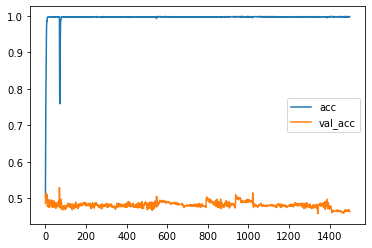

In [64]:
from matplotlib import pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.legend(["acc","val_acc"])
plt.show()

In [128]:
hist_first = hist

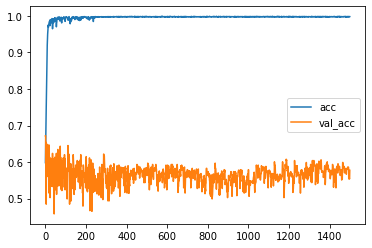

In [125]:
from matplotlib import pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.legend(["acc","val_acc"])
plt.show()

In [126]:
hist.history["val_accuracy"][-1]

0.5775400996208191

In [ ]:
inception.predict()

# OTHER MODELS

In [31]:
import tensorflow

In [422]:
# create the Dense Model

n_features = 768
model = Sequential()
model.add(Input(n_features))
model.add(Dense(200, activation='elu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(200, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss= "binary_crossentropy", optimizer='adam', metrics = ["acc"])
print(model.summary())

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 200)               153800    
_________________________________________________________________
dropout_95 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 200)               800       
_________________________________________________________________
dense_144 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_96 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 201       
Total params: 195,001
Trainable params: 194,601
Non-trainable params: 400
_____________________________________________

In [423]:
history = model.fit(X_train_tr, y_train, validation_data=(X_test_tr, y_test), epochs=100, batch_size=32)

Train on 2584 samples, validate on 623 samples
Epoch 1/100
2584/2584 [==============================] - ETA: 29s - loss: 0.9354 - acc: 0.53 - ETA: 1s - loss: 0.9286 - acc: 0.4779 - ETA: 0s - loss: 0.9303 - acc: 0.483 - ETA: 0s - loss: 0.9102 - acc: 0.487 - ETA: 0s - loss: 0.8932 - acc: 0.484 - 1s 275us/sample - loss: 0.8870 - acc: 0.4876 - val_loss: 0.7002 - val_acc: 0.4783
Epoch 2/100
2584/2584 [==============================] - ETA: 0s - loss: 0.6541 - acc: 0.718 - ETA: 0s - loss: 0.8229 - acc: 0.526 - ETA: 0s - loss: 0.8129 - acc: 0.524 - ETA: 0s - loss: 0.8126 - acc: 0.509 - ETA: 0s - loss: 0.8133 - acc: 0.501 - 0s 109us/sample - loss: 0.8116 - acc: 0.5012 - val_loss: 0.7048 - val_acc: 0.5024
Epoch 3/100
2584/2584 [==============================] - ETA: 0s - loss: 0.9885 - acc: 0.406 - ETA: 0s - loss: 0.8339 - acc: 0.468 - ETA: 0s - loss: 0.7976 - acc: 0.508 - ETA: 0s - loss: 0.7933 - acc: 0.504 - ETA: 0s - loss: 0.7895 - acc: 0.505 - 0s 110us/sample - loss: 0.7852 - acc: 0.5112 - 

Epoch 50/100
2584/2584 [==============================] - ETA: 0s - loss: 0.6829 - acc: 0.531 - ETA: 0s - loss: 0.7016 - acc: 0.483 - ETA: 0s - loss: 0.6951 - acc: 0.518 - ETA: 0s - loss: 0.6939 - acc: 0.522 - ETA: 0s - loss: 0.6934 - acc: 0.526 - 0s 112us/sample - loss: 0.6932 - acc: 0.5236 - val_loss: 0.7047 - val_acc: 0.5056
Epoch 51/100
2584/2584 [==============================] - ETA: 0s - loss: 0.7282 - acc: 0.375 - ETA: 0s - loss: 0.6982 - acc: 0.490 - ETA: 0s - loss: 0.6949 - acc: 0.503 - ETA: 0s - loss: 0.6962 - acc: 0.496 - ETA: 0s - loss: 0.6961 - acc: 0.503 - 0s 114us/sample - loss: 0.6952 - acc: 0.5043 - val_loss: 0.6954 - val_acc: 0.5169
Epoch 52/100
2584/2584 [==============================] - ETA: 0s - loss: 0.7025 - acc: 0.531 - ETA: 0s - loss: 0.6898 - acc: 0.529 - ETA: 0s - loss: 0.6947 - acc: 0.522 - ETA: 0s - loss: 0.6955 - acc: 0.514 - ETA: 0s - loss: 0.6944 - acc: 0.514 - 0s 111us/sample - loss: 0.6944 - acc: 0.5147 - val_loss: 0.6990 - val_acc: 0.4912
Epoch 53/1

Epoch 99/100
2584/2584 [==============================] - ETA: 0s - loss: 0.6801 - acc: 0.593 - ETA: 0s - loss: 0.6867 - acc: 0.552 - ETA: 0s - loss: 0.6855 - acc: 0.554 - ETA: 0s - loss: 0.6851 - acc: 0.556 - ETA: 0s - loss: 0.6872 - acc: 0.551 - 0s 112us/sample - loss: 0.6874 - acc: 0.5499 - val_loss: 0.7021 - val_acc: 0.5169
Epoch 100/100
2584/2584 [==============================] - ETA: 0s - loss: 0.6803 - acc: 0.656 - ETA: 0s - loss: 0.6902 - acc: 0.523 - ETA: 0s - loss: 0.6900 - acc: 0.525 - ETA: 0s - loss: 0.6898 - acc: 0.524 - ETA: 0s - loss: 0.6865 - acc: 0.537 - 0s 112us/sample - loss: 0.6878 - acc: 0.5348 - val_loss: 0.7045 - val_acc: 0.4944


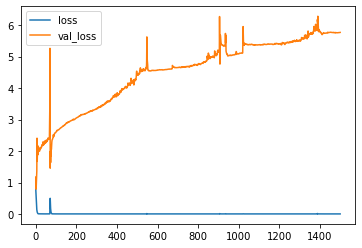

In [62]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(["loss","val_loss"])
plt.show()

In [427]:
pred_binary = np.where(predictions > 0.5, 1, 0)

In [428]:
model.evaluate(X_test_tr, y_test)

623/623 [==============================] - ETA: 0s - loss: 0.7291 - acc: 0.312 - 0s 85us/sample - loss: 0.7045 - acc: 0.4944


[0.7045035697101207, 0.49438202]

In [63]:
predictions = model.predict(X_test_tr)
plt.plot(predictions.flatten())
plt.plot(y_test)

NameError: name 'model' is not defined

In [335]:
# create the LSTM model
n_steps = 120
n_features = 768
model = Sequential()
#model.add(CuDNNLSTM(200, input_shape=(None, n_features), return_sequences= True))
model.add(Input((None, n_features)))
model.add(Bidirectional(LSTM(200, return_sequences = True)))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(Dense(1, activation='elu'))
model.compile(loss='mae', optimizer='adam')
print(model.summary())


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, None, 400)         1550400   
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 400)         0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 50)          20050     
_________________________________________________________________
dense_36 (Dense)             (None, None, 1)           51        
Total params: 1,570,501
Trainable params: 1,570,501
Non-trainable params: 0
_________________________________________________________________
None


In [227]:
# create the Dense Model

n_features = 768
model = Sequential()
model.add(Input(n_features))
model.add(Dense(200, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(200, activation='elu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["acc"])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 200)               153800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 201       
Total params: 194,201
Trainable params: 194,201
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def build_model(max_seq_length):
    # Build model
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
    input_masks = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    input_segments = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
    bert_inputs = [input_word_ids, input_masks, input_segments]
    

    
    albert_model = TFAlbertModel.from_pretrained("albert-base-v1")
    sequence_output, pooled_output = albert_model([input_word_ids, input_masks, input_segments])
    
    #Build LSTM layer
    lstm = tf.keras.layers.LSTM(200, dropout=0.1, recurrent_dropout=0.1)(sequence_output)

    # Build the rest of the classifier 
    dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(pooled_output)
    #dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(dense)
    pred = tf.keras.layers.Dense(2, activation = 'sigmoid', name = "output")(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
    return model

In [8]:
def my_own_pad_sequence(array, maxlen):
    X_tr = []
    for x in array:
        length =  x.shape[0]
        if length > maxlen:
            X_tr.append(x[:maxlen])
        else:
            pad_diff = maxlen - length
            x = np.vstack((x, np.zeros([pad_diff,x.shape[1]])))
            X_tr.append(x)
    return np.array(X_tr)    
    

In [18]:
# X and y for one sequence per day
maxlen = 3000
X_train_tr = my_own_pad_sequence(train_bert_concat_articles, maxlen)
X_test_tr = my_own_pad_sequence(test_bert_concat_articles, maxlen)
y_train = train_labels
y_test = test_labels

# DRAFTS

In [32]:

train_labels = df_diff["BTC-USD"].loc[:"2019-12-31"]
test_labels = df_diff["BTC-USD"].loc["2020-01-01":]
train_labels = train_labels[pd.DatetimeIndex(train_sentences.groupby(train_sentences.index).count().index)]
test_labels = test_labels[pd.DatetimeIndex(test_sentences.groupby(test_sentences.index).count().index)]
assert test_labels.shape == test_bert_concat_articles.shape
assert train_labels.shape == train_bert_concat_articles.shape

In [585]:
d = np.arange(10000).reshape(100,5,2,2,5)
d.strides

(400, 80, 40, 20, 4)

In [611]:
result = np.array([])   
for i in range(0,10):
    result = np.append(result, np.array([i]*5))
result = result.reshape(10,5)
rolling_window_bert_2nd_dim(result,8)

In [10]:
def rolling_window_bert_2nd_dim(a, window):
    shape = (a.shape[0] - window + 1, window, a.shape[1])
    strides = (a.strides[0], a.strides[1]*a.shape[1], a.strides[1])
    #print(shape, strides)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [92]:
#window = 100
#X_train = [rolling_window_bert_2nd_dim(element, window) for element in train_bert_concat_articles]
#X_test = [rolling_window_bert_2nd_dim(element, window) for element in test_bert_concat_articles]
#y_train = train_labels
#y_test = test_labels

In [102]:

#X_train_tr= pad_sequences(train_bert_concat_articles, maxlen=maxlen, padding='post', truncating='post')

In [155]:
X_train_tr = my_own_pad_sequence(train_bert_concat_articles, maxlen)
X_test_tr = my_own_pad_sequence(test_bert_concat_articles, maxlen)

In [82]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 5000
X_train_tr= pad_sequences(X_train, maxlen=maxlen, truncating='post')
X_test_tr= pad_sequences(X_test, maxlen=maxlen, truncating='post')



(array([  5.,  46., 104., 109.,  50.,  22.,  19.,   5.,   1.,   1.,   1.,
          0.,   0.,   0.,   1.]),
 array([ 1478.        ,  2177.26666667,  2876.53333333,  3575.8       ,
         4275.06666667,  4974.33333333,  5673.6       ,  6372.86666667,
         7072.13333333,  7771.4       ,  8470.66666667,  9169.93333333,
         9869.2       , 10568.46666667, 11267.73333333, 11967.        ]),
 <a list of 15 Patch objects>)

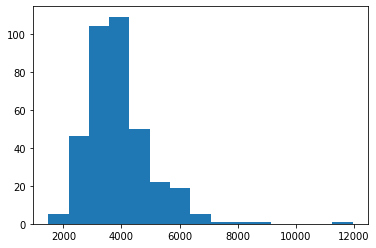

In [63]:
plt.hist(lengths, bins = 15,)